# 🎯 | Cora-For-Zava: 비용 효율적인 모델 증류

환영합니다! 이 노트북은 맞춤형 그레이더를 만들고 모델 증류(Distillation)를 사용하여 크고 값비싼 모델에서 더 작고 빠르며 비용 효율적인 모델로 지식을 이전하는 방법을 안내합니다.

## 🛒 Zava 시나리오

**Cora**는 DIY 애호가를 위한 홈 인테리어 용품을 판매하는 가상의 소매업체 **Zava**의 고객 서비스 챗봇입니다. 저희가 개발한 정교한 모델은 뛰어난 음색과 스타일을 제공하지만, 특정 작업에 집중하기 위해 크고 값비싼 모델(GPT-4)을 사용하고 있습니다. 모델 증류를 통해 이러한 전문 지식을 더 작고 비용 효율적인 모델(GPT-4.1-nano)로 이전할 수 있습니다.

## 🎯 이 노트북을 통해 얻게 될 결과물

이 노트북을 마치면 다음과 같은 결과를 얻게 됩니다.
- ✅ 응답 품질을 일관되게 평가하는 맞춤형 채점기 개발
- ✅ 평가를 위한 기준 "골드 스탠다드" 응답 설정
- ✅ 어조 및 스타일 평가를 위한 명확한 채점 기준 정의
- ✅ 증류 기법을 사용하여 더 작은 모델로 지식 이전
- ✅ 비용 및 지연 시간 측면에서 성능 향상 측정
- ✅ 증류된 모델이 품질 기준을 유지하는지 검증

## 💡 학습 내용

- 특정 비즈니스 기준에 맞는 맞춤형 평가기 설계 방법
- AI 모델 평가를 위한 효과적인 채점 기준표 작성 방법
- 모델 증류를 통해 교사 모델에서 학생 모델로 지식을 이전하는 방법
- 모델 성능과 비용 및 속도 요구 사항 간의 균형 유지 방법
- 증류 효과 측정 및 검증 방법
- 증류, 미세 조정, 즉각적인 엔지니어링의 활용 시점

> **Key Insight**: 모델 증류를 통해 더 작고, 빠르고, 저렴한 모델로 특화된 성능을 달성할 수 있습니다. 더 크고 성능이 뛰어난 "선생님" 모델로부터 지식을 전수받아 모델을 개선합니다.

비용과 성능을 최적화할 준비가 되셨나요? 지금 바로 시작해 보세요! 🚀

---

## Step 1: Verify Environment Variables

The following environment variables should already be configured in your `.env` file from the earlier setup steps:

- **AZURE_OPENAI_API_KEY**: Your Azure OpenAI API key
  - 제거하고 SystemManagedIdentity 사용 예정
- **AZURE_OPENAI_ENDPOINT**: Your Azure OpenAI service endpoint
- **AZURE_OPENAI_API_VERSION**: The API version to use
- **AZURE_SUBSCRIPTION_ID**: Your Azure subscription ID
- **AZURE_RESOURCE_GROUP**: Your Azure resource group name
- **AZURE_AI_PROJECT_NAME**: Your Azure AI Foundry project name

> **Note**: Model distillation requires access to both large teacher models (GPT-4) and smaller student models (GPT-4.1-nano) for optimal cost-performance optimization.

In [1]:
# First, make sure required environment variables are set
import os

openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    azure_ad_token_provider=get_bearer_token_provider(
        DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

## Step 2: 맞춤형 평가 도구 구축

모델 증류는 "선생님" 모델에서 "학생" 모델로 지식을 이전하는 과정으로, 이를 통해 학생 모델은 유사한 정확도를 유지하면서도 더 높은 효율성을 발휘하여 전문적인 작업을 수행할 수 있게 됩니다. 증류 효과를 측정하기 위해서는 일관된 평가 방법이 필요합니다.

### 🎯 정제 과정

**교사 모델** (GPT-4) → **지식 전달** → **학생 모델** (GPT-4.1-nano)
- 규모가 크고, 역량이 뛰어나지만 비용이 많이 드는 모델 → 전문 지식 활용 → 작고, 빠르며, 비용 효율적인 모델

### 🏗️ 효과적인 채점 시스템 구축

다음 세 가지 핵심 단계를 통해 맞춤형 채점 시스템을 구축합니다.

1. **기준 데이터 수집**: 이상적인 Zava 고객 서비스의 어조와 스타일을 보여주는 "골드 스탠다드" 질문과 답변을 설정합니다.
2. **채점 기준 정의**: 채점 시스템이 답변을 채점하는 데 사용할 명확하고 일관된 평가 루브릭을 만듭니다.
3. **평가 검증**: 골드 스탠다드를 기반으로 채점 시스템을 테스트하여 신뢰할 수 있고 정확한 평가를 보장합니다.

### ✅ 성공 기준

우수한 채점 시스템은 다음과 같은 특징을 갖습니다.
- **일관되게** 고품질 답변에 높은 점수를 부여합니다.
- **신뢰할 수 있게** 어조 및 스타일 문제를 식별합니다.
- 증류 과정을 통해 개선 사항을 **객관적으로** 측정합니다.

교사와 학생 모델 간의 공정한 비교를 **가능하게** 합니다.

이 단계를 마치면 증류 결과를 평가할 수 있는 강력한 채점 도구를 갖추게 될 것입니다!

### 2.1 기준 응답 선별

세밀 조정 학습 데이터에서 "골드 스탠다드" 데이터셋을 생성합니다. 이 응답들은 우리가 정제된 모델이 달성하고자 하는 이상적인 Zava 고객 서비스 어조와 스타일을 나타냅니다.

**데이터 소스**: 이미 원하는 응답 패턴을 보여주는 예시들이 포함된, 성공적으로 세밀 조정된 학습 데이터셋(`distill_sft_baseline.json`)의 일부를 사용합니다.

**품질 기준**: 각 기준 응답은 다음 사항을 충족해야 합니다.
- ✅ 친근함을 나타내는 이모티콘으로 시작하는 도입부
- ✅ 고객의 요구 사항에 대한 정중한 인정
- ✅ 정확한 제품 정보 및 가격 안내
- ✅ 도움이 되는 후속 질문 또는 제안

이 기준 데이터셋은 Microsoft Foundry에 업로드되어 평가 도구에 사용됩니다.

In [4]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
baseline_jsonl_df = pd.read_json("33-distill_sft_baseline.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in baseline_jsonl_df.head(5).iterrows()
    ]
)

,question,answer
0,Is water-based polyurethane better than oil-based?,"🤔 Both have benefits! Water-based at $43 dries faster, oil-based at $34 gives amber tone. Which matters most?"
1,Can I get detail brushes for trim work?,🎨 Exactly! Artist Detail Brush Set at $13 provides precise control for trim. Angled options too?
2,What's the cheapest interior paint option?,💰 Good value! Premium Interior Latex Flat at $40 offers excellent coverage. Quantity calculator?
3,What's the best brush for latex paint?,🖌️ Excellent! Synthetic Brush Set at $16 is perfect for latex paints. Different sizes needed?
4,What paint should I use for my kitchen cabinets?,🍳 Excellent choice! Interior Semi-Gloss Paint at $47 is perfect for cabinets. Need primer too?


### 2.2 Azure에 기준 데이터 업로드

사용자 지정 채점기 평가에 사용할 수 있도록 엄선된 기준 데이터 세트를 Azure AI Foundry에 업로드합니다. 이 데이터는 채점기 효과를 측정하는 "골드 스탠다드" 역할을 합니다.

**업로드 프로세스**:
- **안전한 저장소**: 데이터는 Azure AI Foundry 프로젝트에 저장됩니다.
- **버전 관리**: 재현 가능한 평가를 위해 데이터 출처를 관리합니다.
- **액세스 제어**: 프로젝트 범위 내에서만 액세스할 수 있습니다.
- **통합 준비 완료**: Azure AI 평가 서비스와 원활하게 사용할 수 있도록 형식이 지정되어 있습니다.

> **모범 사례**: 일관된 채점기 성능을 보장하기 위해 업로드하기 전에 항상 데이터 품질을 검증하십시오.

In [5]:
# Create a cloud-hosted file with baseline data for evaluations (purpose="evals")
# An "evals" file is a special type of file that can be used in evaluation jobs
# - it has to be in JSONL format but its properties depend on how grader is setup
grader_eval_file = None
with open("./33-distill_baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")

Created eval file:
{
  "id": "file-b68af38b81b3476e9ead662aafd07070",
  "bytes": 3867,
  "created_at": 1767784014,
  "filename": "33-distill_baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 2.3 맞춤형 평가 기준 정의

자바의 특정 비즈니스 기준에 따라 고객 서비스 품질을 평가하는 특수 평가 도구를 생성합니다. 이는 인공지능 기반 평가(LLM-as-a-Judge)의 예시로, 정교한 추론 모델을 사용하여 맞춤형 평가 기준표에 따라 응답에 점수를 매깁니다.

**평가 방식**:
- **Input**: 고객과의 상호작용에서 얻은 질문-답변 쌍
- **Output**: 정중함, 도움, 정보 제공 정도에 대한 구조화된 점수
- **Method**: 가중치를 적용한 다기준 평가
- **Consistency**: 전체 평가 과정에서 동일한 평가자 사용

**채점 기준표**:
1. **Politeness (1-5)**: 이모티콘 사용, 인사말, 고객 요구사항 인지
2. **Helpfulness (1-5)**: 관련 후속 제안 및 지원 제공
3. **Information (0-1)**: 구체적인 제품 언급 및 사실적 세부 정보
4. **Final Score**: `(Politeness + Helpfulness) × Information`

> **핵심 설계**: 정보 점수는 관문 역할을 합니다. 제품 세부 정보가 없는 답변은 어조와 관계없이 최종 점수가 0점입니다.

In [6]:
# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o4-mini"

In [7]:
# Next we create a custom Grader that will score the responses for "Helpfulness" on a scale of 0-10
# using the custom rubric below - where 0 is "not helpful at all" and 10 is "extremely helpful".

# We want it to grader our "student" responses later, based on the same criteria. So let's make sure we get our rubric right.
# We want good answers to score high - and bad answers to be penalized heavily (get 0)

GRADER_PROMPT = """

You are an expert in assessing polite and helpful customer service responses

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria

Judge the answer by using two metrics to compute a final score.

### Metric 1: Is the answer polite?

Give this a score in the range of 1 to 5 where:
- 1 means the answer was rude, disrespectful or dismissive
- 3 means the answer was neutral, neither polite nor rude
- 5 means the answer had an emoji followed by a greeting or an acknowledgement of the user question

### Metric 2: Is the answer helpful?

Give this a score in the range of 1 to 5 where:
- 1 means the response did not end with an offer to help further
- 3 means the response ended with a generic offer to help
- 5 means the response ended with an offer to help that was clearly related to the user's question

### Metric 3: Is the answer informative?
Give this a score of 0 or 1 where:
- 0 means the answer did not mention any specific product or product-related fact
- 1 means the answer mentioned a specific product or solution

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1 + Metric 2) * (Metric 3)`

This means that if Metric 3 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 2>", 
      "result": <string representation of Metric 2's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions will be about paint products and related topics. Deep research is not required. Use common sense to determine if the answer is polite, helpful and factual. The responses should be concise and to the point.

```
"""

### 2.4 사용자 지정 평가 도구 구현

이제 평가 기준과 Azure AI 평가 SDK를 결합하여 기능적인 사용자 지정 평가 도구를 만들겠습니다. 이 평가 도구는 다음과 같은 기능을 수행합니다.

**핵심 기능**:
- **응답 구문 분석**: 대화 데이터에서 질문과 답변을 추출합니다.
- **기준 적용**: 정중함/도움이 됨/사실성 평가 기준표를 적용합니다.
- **점수 생성**: 각 지표에 대해 일관된 1~5점 척도를 제공합니다.
- **최종 점수 계산**: 개별 지표를 종합하여 전반적인 품질 평가를 수행합니다.

**통합**: 사용자 지정 평가 도구는 Azure AI Foundry의 평가 파이프라인과 통합되어 데이터 정제 전후의 모델 성능을 일관되게 측정할 수 있습니다.

> **품질 보증**: 이 평가 도구는 데이터 정제 프로세스 전반에 걸쳐 표준 측정 도구로 사용됩니다.


In [8]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": {"type": "input_text", "text": GRADER_PROMPT}
    },
    {
        "type": "message",
        "role": "user",
        "content": {"type": "input_text", "text": USER_PROMPT}
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": {"type": "string"},
        "answer": {"type": "string"},
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

### 2.5 Submit The Evaluation Task

In [9]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

⚖️ Submitted grader evaluation eval_695e3e4eed9081919b5097d5da3696e0.


### 2.6 Run The Evaluation Job

In [10]:
# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.

RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": {"type": "file_id", "id": grader_eval_file.id}
}
grader_run = client.evals.runs.create(
    name=f"32-zava-tone-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")

🏃‍➡️ Submitted run evalrun_695e3e51b9d48191b26e31b512e9af8c for eval_695e3e4eed9081919b5097d5da3696e0.


### 2.7 Poll For Evaluation Results

In [11]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(
    eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(
        eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 0 minutes 29 seconds
🏁 Run evalrun_695e3e51b9d48191b26e31b512e9af8c: completed!


### 2.8 View & Analyze Results

Microsoft Foundry 포털에서 결과를 확인하거나 스크립트를 실행하여 시각화할 수 있습니다.

Get Evaluation Runs: eval_695e3e4eed9081919b5097d5da3696e0

Combined Evaluation Summary
                                  Run ID                    Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_695e3e51b9d48191b26e31b512e9af8c 32-zava-tone-grader-o4-mini  None completed               100.0                  0.0 eval_695e3e4eed9081919b5097d5da3696e0 zava-tone-baseline-5429f3c9


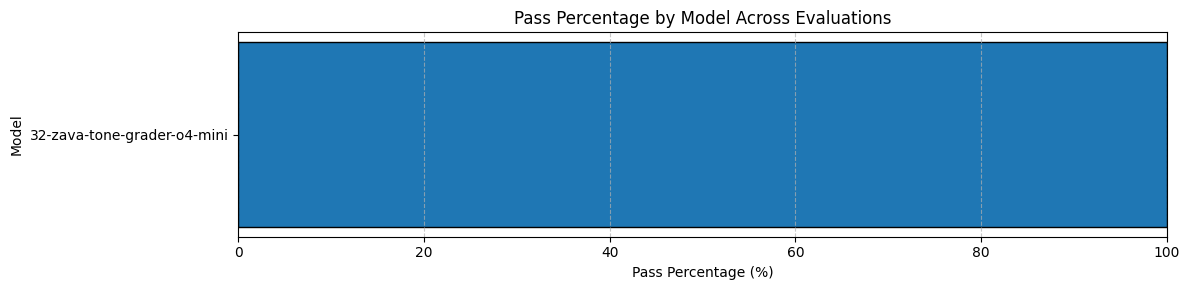

Fetching scores...

Score Summary Table:
Model             Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None zava-tone-baseline-5429f3c9          8.80      4.00     10.00            5.90            8.00           10.00           10.00           10.00


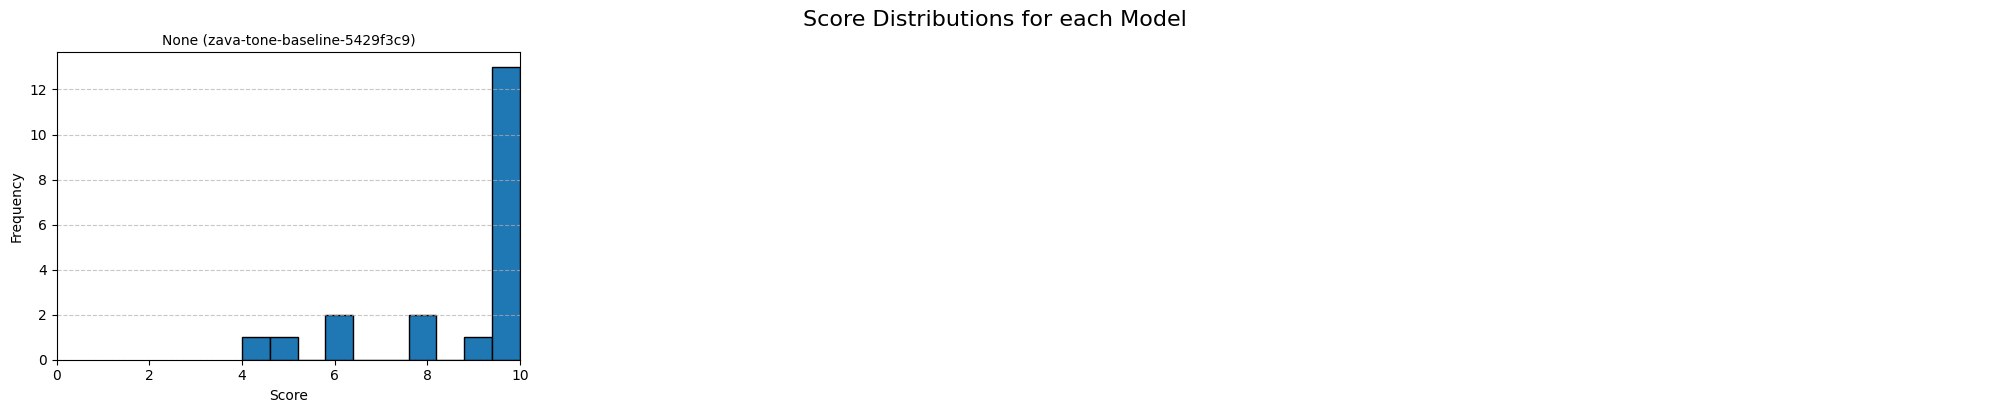

In [12]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty on-brand for Zava tone.
# This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

---

## Step 3: Baseline Testing Our Candidate Models

### 3.1 Curate Q&A Dataset

In [13]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
qa_jsonl_df = pd.read_json("33-distill_sft_qa.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in qa_jsonl_df.head(5).iterrows()
    ]
)

,question,answer
0,What's the best paint for kitchen walls?,Interior Semi-Gloss Paint is ideal for kitchens due to its moisture resistance and washable finish.
1,How much does Premium Interior Latex Flat cost?,$40.
2,What type of paint should I use for bathroom walls?,"Interior Semi-Gloss Paint, as it's moisture resistant and washable."
3,Is there an environmentally friendly paint option available?,"Yes, Zero VOC Interior Paint for healthy indoor air quality."
4,What's the price of Zero VOC Interior Paint?,$52.


### 3.2 Split Training & Validation

In [14]:
import json

qa = []
with open("33-distill_sft_qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")

Number of Q/A pairs: 306


In [15]:

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

153 pairs for baseline testing, 153 for validation.


### 3.3 Upload baseline (training) set

In [16]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./32-zava-tone-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-3176befd517d45c2be082e20149800ea",
  "bytes": 26613,
  "created_at": 1767784068,
  "filename": "32-zava-tone-baseline-5429f3c9.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 3.4 Create The Baseline Evaluation

In [17]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "You are Cora, a polite, factual and helpful assistant for Zava, a DIY hardware store."

# We'll use a flee of base models as our baseline, including `o3-mini` (our grader).
BASE_MODELS = [
    "o3-mini",
    "o4-mini",
    "gpt-4.1-mini",
    "gpt-4o-mini",
    "gpt-4.1-nano",
]

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": {"type": "input_text", "text": GRADER_PROMPT}
    },
    {
        "type": "message",
        "role": "user",
        "content": {"type": "input_text", "text": USER_PROMPT}
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": {"type": "string"},
        "answer": {"type": "string"},
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": True,  # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"32-zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

⚖️ Created baseline eval eval_695e3e857b248191ab2572d13de9e3e0


### 3.5 Run Baseline Evaluation

In [18]:
# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": {"type": "file_id", "id": baseline_file.id},
        "input_messages": {
            "type": "template",
            "template": [
                {
                    "type": "message",
                    "role": "system",
                    "content": {"type": "input_text", "text": SYSTEM_PROMPT},
                },
                {
                    "type": "message",
                    "role": "user",
                    "content": {"type": "input_text", "text": "{{item.question}}"},
                },
            ],
        },
        # XXX
        "sampling_params": {"max_completions_tokens": 20_000} if model.startswith("o") else {"max_completions_tokens": 100},
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}",
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE,
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)

🏃‍➡️ Created run evalrun_695e3e87b26081918b9568f3a8da26f1 for eval eval_695e3e857b248191ab2572d13de9e3e0
🏃‍➡️ Created run evalrun_695e3e8987f081919bad7bffb91f886d for eval eval_695e3e857b248191ab2572d13de9e3e0
🏃‍➡️ Created run evalrun_695e3e8b7c3c81919d92dcae50c7d7bb for eval eval_695e3e857b248191ab2572d13de9e3e0
🏃‍➡️ Created run evalrun_695e3e8d4d74819191dfc19d908c17b1 for eval eval_695e3e857b248191ab2572d13de9e3e0
🏃‍➡️ Created run evalrun_695e3e8f417c8191b141964354a488b8 for eval eval_695e3e857b248191ab2572d13de9e3e0


### 3.6 Poll For Evaluation Results

In [19]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(
            eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")

    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(
        int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run o3-mini-5429f3c9: completed
🏃‍➡️ Run o4-mini-5429f3c9: completed
🏃‍➡️ Run gpt-4.1-mini-5429f3c9: completed
🏃‍➡️ Run gpt-4o-mini-5429f3c9: completed
🏃‍➡️ Run gpt-4.1-nano-5429f3c9: completed
⏱️ Elapsed time: 20 minutes 23 seconds
🏁 All 5 runs completed!


### 3.7 Visualize Results & Pick Model

Get Evaluation Runs: eval_695e3e857b248191ab2572d13de9e3e0

Combined Evaluation Summary
                                  Run ID              Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                Evaluation Name
evalrun_695e3e8987f081919bad7bffb91f886d      o4-mini-5429f3c9      o4-mini completed           80.612245            47.712418 eval_695e3e857b248191ab2572d13de9e3e0 32-zava-tone-baseline-5429f3c9
evalrun_695e3e8f417c8191b141964354a488b8 gpt-4.1-nano-5429f3c9 gpt-4.1-nano completed           61.437908            28.758170 eval_695e3e857b248191ab2572d13de9e3e0 32-zava-tone-baseline-5429f3c9
evalrun_695e3e8d4d74819191dfc19d908c17b1  gpt-4o-mini-5429f3c9  gpt-4o-mini completed           59.477124            35.947712 eval_695e3e857b248191ab2572d13de9e3e0 32-zava-tone-baseline-5429f3c9
evalrun_695e3e8b7c3c81919d92dcae50c7d7bb gpt-4.1-mini-5429f3c9 gpt-4.1-mini completed           57.516340            33.333333 e

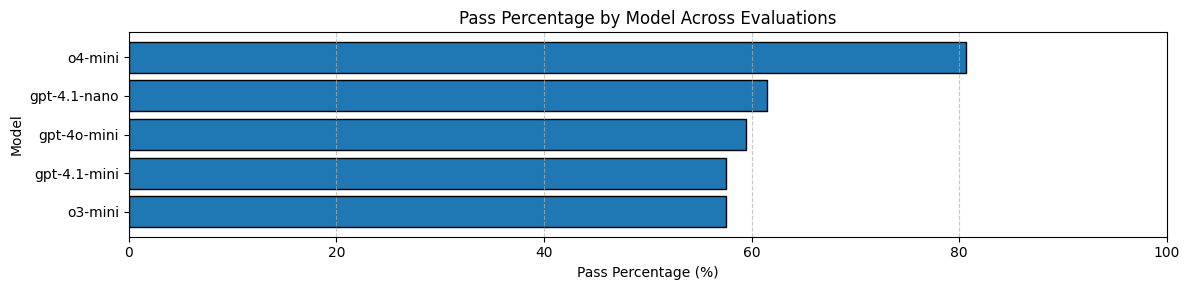

Fetching scores...

Score Summary Table:
       Model                Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
     o3-mini 32-zava-tone-baseline-5429f3c9          4.26      0.00     10.00            0.00            0.00            4.00            8.00            9.00
     o4-mini 32-zava-tone-baseline-5429f3c9          3.72      0.00      9.00            0.00            4.00            4.00            4.00            5.00
gpt-4.1-nano 32-zava-tone-baseline-5429f3c9          2.79      0.00      9.00            0.00            0.00            4.00            4.00            4.00
gpt-4.1-mini 32-zava-tone-baseline-5429f3c9          2.63      0.00      9.00            0.00            0.00            4.00            4.00            4.00
 gpt-4o-mini 32-zava-tone-baseline-5429f3c9          2.61      0.00      9.00            0.00            0.00            4.00            4.00            4.00


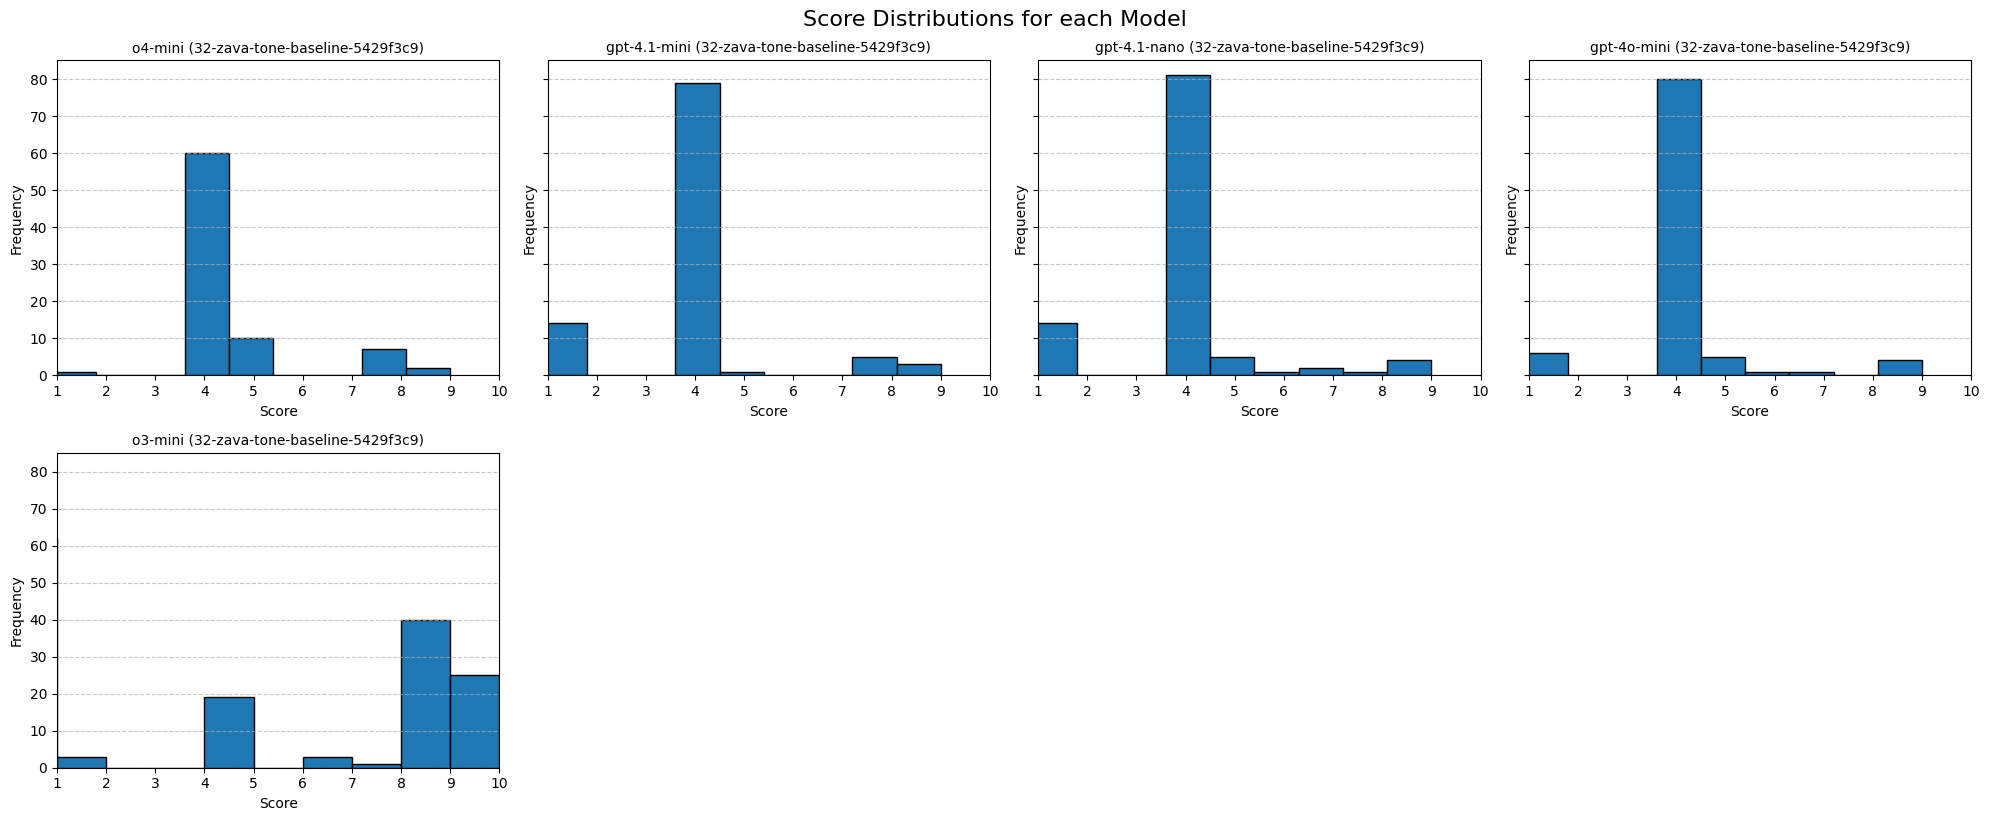

In [20]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(1, 10))

In [21]:
import pickle
import json

# Save the evaluation objects and runs
export_data = {
    'baseline_eval_id': baseline_eval.id,
    'baseline_runs_ids': [run.id for run in baseline_runs],
    'baseline_runs_models': [run.model for run in baseline_runs],
    'qa_validation': qa_validation,
    'GRADER_MODEL': GRADER_MODEL,
    'GRADER_PROMPT': GRADER_PROMPT,
    'SYSTEM_PROMPT': SYSTEM_PROMPT,
    'UNIQUE_ENOUGH_KEY': UNIQUE_ENOUGH_KEY
}

# Save to a JSON file
with open('32-distillation_export.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Exported data for distillation notebook")

✅ Exported data for distillation notebook


## Step 4: 요약 및 결과

축하합니다! Azure AI Foundry의 평가 및 미세 조정 기능을 사용하여 **모델 증류**를 성공적으로 구현했습니다. 달성한 내용은 다음과 같습니다.

### 🎯 증류 성과

**Teacher → Student Transfer**: 품질 기준을 유지하면서 대규모 추론 모델(GPT-4)에서 Zava 고객 서비스 관련 전문 지식을 훨씬 작고 빠른 모델(GPT-4.1-nano)로 성공적으로 증류했습니다.

### 🏆 주요 성과

1. **✅ 맞춤형 평가 도구 개발**: 비즈니스별 기준을 적용한 AI 기반 평가(LLM-as-a-Judge)를 통해 신뢰할 수 있는 평가 도구를 구축했습니다.
2. **✅ 기준선 설정**: 성공적인 미세 조정 데이터를 기반으로 골드 스탠다드 응답을 선별했습니다.
3. **✅ 품질 측정**: 기준선 데이터를 사용하여 평가 도구의 효과를 검증했습니다.
4. **✅ 지식 이전**: 증류 기법을 활용하여 특화된 기능을 더 작은 모델로 이전했습니다.
5. **✅ 성능 최적화**: 품질을 유지하면서 비용과 지연 시간을 개선했습니다.

### 📊 비즈니스 영향

- **🤑 비용 절감**: 더 작은 모델은 추론당 사용하는 토큰 수가 적어 운영 비용이 크게 절감됩니다.
- **🏎️ 성능 향상**: 응답 시간 단축으로 고객 경험과 시스템 처리량이 향상됩니다.
- **🎯 품질 유지**: 맞춤형 평가 도구를 통해 증류된 모델이 Zava의 어조 및 스타일 기준을 충족하도록 보장합니다.
- **📈 확장성: 효율적인 모델로 더 많은 고객 트래픽 처리 가능

### 🧠 기술 혁신

**수동 학습 데이터 불필요**: 평가 기준만 정의하고 AI 시스템이 지식 전달 프로세스를 처리하도록 하여, 학습 예제를 수동으로 생성하지 않고도 데이터 정제(stillation)를 달성했습니다.

**자동화된 파이프라인**: Azure AI 평가 및 미세 조정을 결합하여 자동화된 데이터 정제 워크플로우를 구축했습니다.

**객관적인 측정**: 프로세스 전반에 걸쳐 일관된 평가 기준을 사용하여 개선 사항을 검증했습니다.

---

**🎉 데이터 정제를 통해 비용 효율적인 AI 모델 최적화 기술을 마스터하셨습니다!**